Fit Baker et al data with dynamical adaptive model

$$\tau_r \frac{dr}{dt} = -r + (1-a_s)I_s(t) + (1-a_p)I_p(t)$$

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from disp import set_font_size

FPS = 8.5
DT = 1/FPS
NT = 300
T = DT*np.arange(NT) - 10

IT_STIM = (85, 170)
IDUR_STIM = IT_STIM[1] - IT_STIM[0]
DUR_STIM = DT*IDUR_STIM

T_COLS = [f'IT_{it}' for it in range(NT)]

LOAD_FILE = 'data/simple/baker.csv'

In [2]:
# load data
df = pd.read_csv(LOAD_FILE)
expt_ids = np.sort(np.unique(df['EXPT_ID']))

df

EXPT_ID STIM        LINE  FLY    ROI  ROI_USED      IT_0      IT_1  \
0          0    S      R70G01    0  somas     False -0.286139 -0.251529   
1          0    P      R70G01    0  somas     False -0.090690 -0.071585   
2          1    S      R70G01    1  somas     False -0.074163 -0.052967   
3          1    P      R70G01    1  somas     False -0.094280 -0.175828   
4          2    S      R70G01    2  somas     False -0.359071 -0.296972   
..       ...  ...         ...  ...    ...       ...       ...       ...   
443      221    P  vPN1_split    0  somas     False  0.308926  0.069519   
444      222    S  vPN1_split    1  somas     False  0.268154  0.517779   
445      222    P  vPN1_split    1  somas     False  0.563747  0.506288   
446      223    S  vPN1_split    2  somas     False  0.023391  0.023677   
447      223    P  vPN1_split    2  somas     False  0.064481  0.055382   

         IT_2      IT_3  ...  IT_290  IT_291  IT_292  IT_293  IT_294  IT_295  \
0   -0.214845 -0.085881  ...     NaN     NaN     NaN     NaN     NaN     NaN   
1    0.027546 -0.089212  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2   -0.226459 -0.086673  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3   -0.132839 -0.155376  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4   -0.283760 -0.206650  ...     NaN     NaN     NaN     NaN     NaN     NaN   
..        ...       ...  ...     ...     ...     ...     ...     ...     ...   
443 -0.028961 -0.103122  ...     NaN     NaN     NaN     NaN     NaN     NaN   
444  0.526319  0.353496  ...     NaN     NaN     NaN     NaN     NaN     NaN   
445  0.271983  0.002747  ...     NaN     NaN     NaN     NaN     NaN     NaN   
446  0.009701  0.006185  ...     NaN     NaN     NaN     NaN     NaN     NaN   
447  0.086223  0.063935  ...     NaN     NaN     NaN     NaN     NaN     NaN   

     IT_296  IT_297  IT_298  IT_299  
0       NaN     NaN     NaN     NaN  
1       NaN     NaN     NaN     NaN  
2       NaN     NaN     NaN     NaN  
3       NaN     NaN     NaN     NaN  
4       NaN     NaN     NaN     NaN  
..      ...     ...     ...     ...  
443     NaN     NaN     NaN     NaN  
444     NaN     NaN     NaN     NaN  
445     NaN     NaN     NaN     NaN  
446     NaN     NaN     NaN     NaN  
447     NaN     NaN     NaN     NaN  

[448 rows x 306 columns]

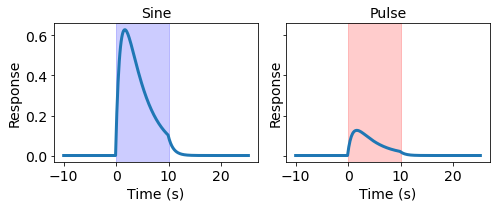

In [3]:
# define smln & obj function
def smlt(tau_r, tau_a, x_s, x_p, t_0, inp):
    """Simulate response to sine or pulse inputs."""
    i_s = np.zeros(NT)
    i_p = np.zeros(NT)
    
    if inp == 's':
        i_s[(t_0 <= T)&(T < t_0+DUR_STIM)] = 1
    elif inp == 'p':
        i_p[(t_0 <= T)&(T < t_0+DUR_STIM)] = 1
 
    r = np.nan*np.zeros(NT)
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(T[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

# test
r_test_s = smlt(tau_r=1, tau_a=4, x_s=1, x_p=.2, t_0=0, inp='s')
r_test_p = smlt(tau_r=1, tau_a=4, x_s=1, x_p=.2, t_0=0, inp='p')

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True, tight_layout=True)
axs[0].plot(T, r_test_s, lw=3)
axs[0].set_title('Sine')
axs[1].plot(T, r_test_p, lw=3)
axs[1].set_title('Pulse')

for ax, c in zip(axs, ['b', 'r']):
    ax.axvspan(0, 10, color=c, alpha=.2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Response')
    
set_font_size(axs, 14)

In [4]:
# set initial params
cols_param_0_dyn = ['EXPT_ID', 'T_0', 'R_0', 'TAU_R', 'TAU_A', 'X_S', 'X_P']
data_param_0_dyn = [
    {'EXPT_ID': 52, 'T_0': 0, 'R_0': .1, 'TAU_R': 7, 'TAU_A': 100, 'X_S': -3, 'X_P': -3},
    {'EXPT_ID': 77, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 3, 'X_P': 10},
    {'EXPT_ID': 78, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 79, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 80, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 81, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3.5, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 82, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 104, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 3, 'X_P': 10},
    {'EXPT_ID': 105, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 2, 'X_P': 10},
    {'EXPT_ID': 106, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 107, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 108, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 109, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 112, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': -3},
    {'EXPT_ID': 118, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 141, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 13, 'X_P': 2},
    {'EXPT_ID': 142, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0},
    {'EXPT_ID': 143, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0},
    {'EXPT_ID': 144, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0},
    {'EXPT_ID': 145, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0},
    {'EXPT_ID': 165, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 5, 'X_P': 5},
    {'EXPT_ID': 168, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 3, 'X_S': 0, 'X_P': 8},
    {'EXPT_ID': 171, 'T_0': 0, 'R_0': .1, 'TAU_R': 1, 'TAU_A': 5, 'X_S': 0, 'X_P': 5},
    {'EXPT_ID': 176, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 0},
    {'EXPT_ID': 177, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0},
    {'EXPT_ID': 183, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 0},
    {'EXPT_ID': 184, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 10, 'X_P': 0},
    {'EXPT_ID': 185, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 0},
    {'EXPT_ID': 201, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 0},
    {'EXPT_ID': 202, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 1.5, 'X_S': 10, 'X_P': 10},
    {'EXPT_ID': 204, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 3, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 205, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 206, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 207, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 208, 'T_0': 0, 'R_0': .1, 'TAU_R': .7, 'TAU_A': 2, 'X_S': 0, 'X_P': 10},
    {'EXPT_ID': 210, 'T_0': 0, 'R_0': .1, 'TAU_R': .5, 'TAU_A': 1, 'X_S': 15, 'X_P': 3},
]

df_param_0_dyn = pd.DataFrame(columns=cols_param_0_dyn, data=data_param_0_dyn)
df_param_0_dyn.to_csv('data/simple/baker_dyn_fit_param_0.csv', index=False)

In [5]:
# objective function for dynamical system fit
def obj_lin(param, t_0, r_s, r_p):
    # unpack parameters (5 total)
    r_0 = param[0]  # y offset
    tau_r, tau_a, x_s, x_p = param[1:]
    
    pred_s = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='s') + r_0
    pred_p = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='p') + r_0
    
    # compute error
    sq_err = np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2)
    
    return sq_err

BDS_OBJ = [(None, None), (.001, None), (.001, None), (None, None), (None, None)]

In [6]:
# loop over expt_ids

cols_pred_dyn = df.columns
data_pred_dyn = []

cols_param_dyn = ['EXPT_ID', 'LINE', 'FLY', 'ROI', 'ROI_USED', 'FIT_ERR', 'SUCCESS'] + ['T_0', 'R_0', 'TAU_R', 'TAU_A', 'X_S', 'X_P']
data_param_dyn = []

for expt_id in expt_ids:
    sys.stdout.write('.')
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    line = row_s['LINE']
    fly = row_s['FLY']
    roi = row_s['ROI']
    roi_used = row_s['ROI_USED']
    
    r_s = np.array(row_s[T_COLS])
    r_p = np.array(row_p[T_COLS])
    
    # set initial params
    if expt_id in list(df_param_0_dyn['EXPT_ID']):
        row_param_0 = df_param_0_dyn[df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
        p_0 = np.array([row_param_0['R_0'], row_param_0['TAU_R'], row_param_0['TAU_A'], row_param_0['X_S'], row_param_0['X_P']])
    else:
        p_0 = np.array([0, 2, 5, 1., 1.])  # r_0, tau_r, tau_a, x_s, x_p
    
    # fit model
    obj_best = np.inf
    for t_0 in -DT*np.arange(-2, 9):
        fit_rslt = optimize.minimize(obj_lin, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ)  # try default (BFGS) first
        if not fit_rslt.success:  # try Nelder-Mead
            fit_rslt = optimize.minimize(obj_lin, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ, method='Nelder-Mead', options={'maxiter': 1e5})
            
        if fit_rslt.fun < obj_best:
            fit_rslt_best = copy(fit_rslt)
            t_0_best = t_0
            
            obj_best = fit_rslt.fun
            
    fit_rslt = fit_rslt_best
    t_0 = t_0_best
        
    p_found = fit_rslt.x
    
    # unpack params
    r_0, tau_r, tau_a, x_s, x_p = p_found
    
    # make predictions
    pred_s = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='s') + r_0
    pred_p = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='p') + r_0
    
    # store predictions
    pred_dict_s = {'EXPT_ID': expt_id, 'STIM': 'S', 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    pred_dict_p = {'EXPT_ID': expt_id, 'STIM': 'P', 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    
    # add time cols
    for it, t_col in enumerate(T_COLS):
        pred_dict_s[t_col] = pred_s[it]
        pred_dict_p[t_col] = pred_p[it]
        
    data_pred_dyn.extend([pred_dict_s, pred_dict_p])
    
    # store params
    param_dict = {'EXPT_ID': expt_id, 'LINE': line, 'FLY': fly, 'ROI': roi, 'ROI_USED': roi_used}
    param_dict['FIT_ERR'] = np.sqrt(np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2))
    param_dict['SUCCESS'] = fit_rslt.success
    param_dict['T_0'] = t_0
    param_dict['R_0'] = r_0
    param_dict['TAU_R'] = tau_r
    param_dict['TAU_A'] = tau_a
    param_dict['X_S'] = x_s
    param_dict['X_P'] = x_p
    
    data_param_dyn.append(param_dict)

................................................................................................................................................................................................................................

In [7]:
df_param_dyn = pd.DataFrame(columns=cols_param_dyn, data=data_param_dyn)
df_pred_dyn = pd.DataFrame(columns=cols_pred_dyn, data=data_pred_dyn)

In [8]:
df_param_dyn.to_csv('data/simple/baker_dyn_fit_param.csv', index=False)
df_pred_dyn.to_csv('data/simple/baker_dyn_fit_pred.csv', index=False)

# Examine fits

In [4]:
df_param_0_dyn = pd.read_csv('data/simple/baker_dyn_fit_param_0.csv')

df_param_dyn = pd.read_csv('data/simple/baker_dyn_fit_param.csv')
df_pred_dyn = pd.read_csv('data/simple/baker_dyn_fit_pred.csv')

In [5]:
df_param_0_dyn

EXPT_ID  T_0  R_0  TAU_R  TAU_A  X_S  X_P
0        52    0  0.1    7.0  100.0   -3   -3
1        77    0  0.1    0.7    2.0    3   10
2        78    0  0.1    0.7    2.0    0   10
3        79    0  0.1    1.0    3.0    0   10
4        80    0  0.1    1.0    3.0    0   10
5        81    0  0.1    1.0    3.5    0   10
6        82    0  0.1    0.7    2.0    0   10
7       104    0  0.1    0.7    2.0    3   10
8       105    0  0.1    0.7    2.0    2   10
9       106    0  0.1    0.7    2.0    0   10
10      107    0  0.1    0.7    2.0    0   10
11      108    0  0.1    0.7    2.0    0   10
12      109    0  0.1    0.7    2.0    0   10
13      112    0  0.1    0.7    2.0   10   -3
14      118    0  0.1    0.7    2.0    0   10
15      141    0  0.1    0.7    2.0   13    2
16      142    0  0.1    0.5    1.0   15    0
17      143    0  0.1    0.5    1.0   15    0
18      144    0  0.1    0.5    1.0   15    0
19      145    0  0.1    0.5    1.0   15    0
20      165    0  0.1    0.7    2.0    5    5
21      168    0  0.1    1.0    3.0    0    8
22      171    0  0.1    1.0    5.0    0    5
23      176    0  0.1    0.7    2.0   10    0
24      177    0  0.1    0.5    1.0   15    0
25      183    0  0.1    0.7    1.5   10    0
26      184    0  0.1    0.7    2.0   10    0
27      185    0  0.1    0.7    1.5   10    0
28      201    0  0.1    0.5    1.0   15    0
29      202    0  0.1    0.7    1.5   10   10
30      204    0  0.1    0.7    3.0    0   10
31      205    0  0.1    0.7    2.0    0   10
32      206    0  0.1    0.7    2.0    0   10
33      207    0  0.1    0.7    2.0    0   10
34      208    0  0.1    0.7    2.0    0   10
35      210    0  0.1    0.5    1.0   15    3

In [6]:
df_param_dyn

EXPT_ID        LINE  FLY                   ROI  ROI_USED   FIT_ERR  \
0          0      R70G01    0                 somas     False  0.275200   
1          1      R70G01    1                 somas     False  0.186212   
2          2      R70G01    2                 somas     False  0.248414   
3          3      R70G01    3                 somas     False  0.455963   
4          4      R70G01    4                 somas     False  0.229018   
..       ...         ...  ...                   ...       ...       ...   
219      219     VT34811    0                 somas     False  0.276087   
220      220     VT34811    0  ascending projection     False  0.037801   
221      221  vPN1_split    0                 somas     False  0.404112   
222      222  vPN1_split    1                 somas     False  1.205977   
223      223  vPN1_split    2                 somas     False  0.096240   

     SUCCESS       T_0       R_0     TAU_R        TAU_A       X_S       X_P  
0       True -0.000000  0.028882  6.202615    30.336758 -4.958290 -2.597432  
1       True  0.117647  0.025128  3.835468    21.821295 -4.163967 -1.472075  
2       True -0.000000  0.055962  6.017162    15.058055 -6.248007 -2.095952  
3       True -0.000000 -0.014227  6.016828    11.820576 -5.679735 -2.118245  
4       True -0.000000  0.019831  6.434825    55.496220 -4.415761 -2.863647  
..       ...       ...       ...       ...          ...       ...       ...  
219     True -0.000000  0.039119  1.799608  1440.994269 -0.049828  2.494657  
220     True -0.000000 -0.001886  1.298841    27.643238  0.098451  2.457383  
221     True -0.588235 -0.014702  4.151226     6.155551  8.332263  2.353217  
222     True  0.235294 -0.095665  5.924070    90.705238  2.390705  0.604586  
223     True -0.000000 -0.000413  3.664384    10.471628  6.416873  1.021095  

[224 rows x 13 columns]

In [7]:
df_pred_dyn

EXPT_ID STIM        LINE  FLY    ROI  ROI_USED      IT_0      IT_1  \
0          0    S      R70G01    0  somas     False  0.028882  0.028882   
1          0    P      R70G01    0  somas     False  0.028882  0.028882   
2          1    S      R70G01    1  somas     False  0.025128  0.025128   
3          1    P      R70G01    1  somas     False  0.025128  0.025128   
4          2    S      R70G01    2  somas     False  0.055962  0.055962   
..       ...  ...         ...  ...    ...       ...       ...       ...   
443      221    P  vPN1_split    0  somas     False -0.014702 -0.014702   
444      222    S  vPN1_split    1  somas     False -0.095665 -0.095665   
445      222    P  vPN1_split    1  somas     False -0.095665 -0.095665   
446      223    S  vPN1_split    2  somas     False -0.000413 -0.000413   
447      223    P  vPN1_split    2  somas     False -0.000413 -0.000413   

         IT_2      IT_3  ...    IT_290    IT_291    IT_292    IT_293  \
0    0.028882  0.028882  ... -0.290743 -0.284681 -0.278734 -0.272899   
1    0.028882  0.028882  ... -0.138556 -0.135380 -0.132264 -0.129208   
2    0.025128  0.025128  ... -0.042054 -0.039993 -0.037996 -0.036059   
3    0.025128  0.025128  ...  0.001377  0.002106  0.002812  0.003497   
4    0.055962  0.055962  ... -0.253385 -0.247337 -0.241407 -0.235593   
..        ...       ...  ...       ...       ...       ...       ...   
443 -0.014702 -0.014702  ...  0.005929  0.005344  0.004776  0.004224   
444 -0.095665 -0.095665  ...  0.071310  0.067994  0.064744  0.061559   
445 -0.095665 -0.095665  ... -0.053439 -0.054277 -0.055099 -0.055905   
446 -0.000413 -0.000413  ...  0.059876  0.057941  0.056067  0.054254   
447 -0.000413 -0.000413  ...  0.009181  0.008873  0.008575  0.008286   

       IT_294    IT_295    IT_296    IT_297    IT_298    IT_299  
0   -0.267175 -0.261559 -0.256051 -0.250646 -0.245344 -0.240143  
1   -0.126209 -0.123268 -0.120382 -0.117551 -0.114773 -0.112048  
2   -0.034183 -0.032363 -0.030600 -0.028890 -0.027234 -0.025627  
3    0.004160  0.004803  0.005427  0.006031  0.006617  0.007185  
4   -0.229892 -0.224303 -0.218823 -0.213451 -0.208183 -0.203019  
..        ...       ...       ...       ...       ...       ...  
443  0.003688  0.003167  0.002660  0.002168  0.001690  0.001226  
444  0.058436  0.055376  0.052376  0.049436  0.046555  0.043730  
445 -0.056695 -0.057468 -0.058227 -0.058971 -0.059699 -0.060414  
446  0.052499  0.050800  0.049156  0.047564  0.046024  0.044533  
447  0.008007  0.007737  0.007475  0.007222  0.006977  0.006739  

[448 rows x 306 columns]

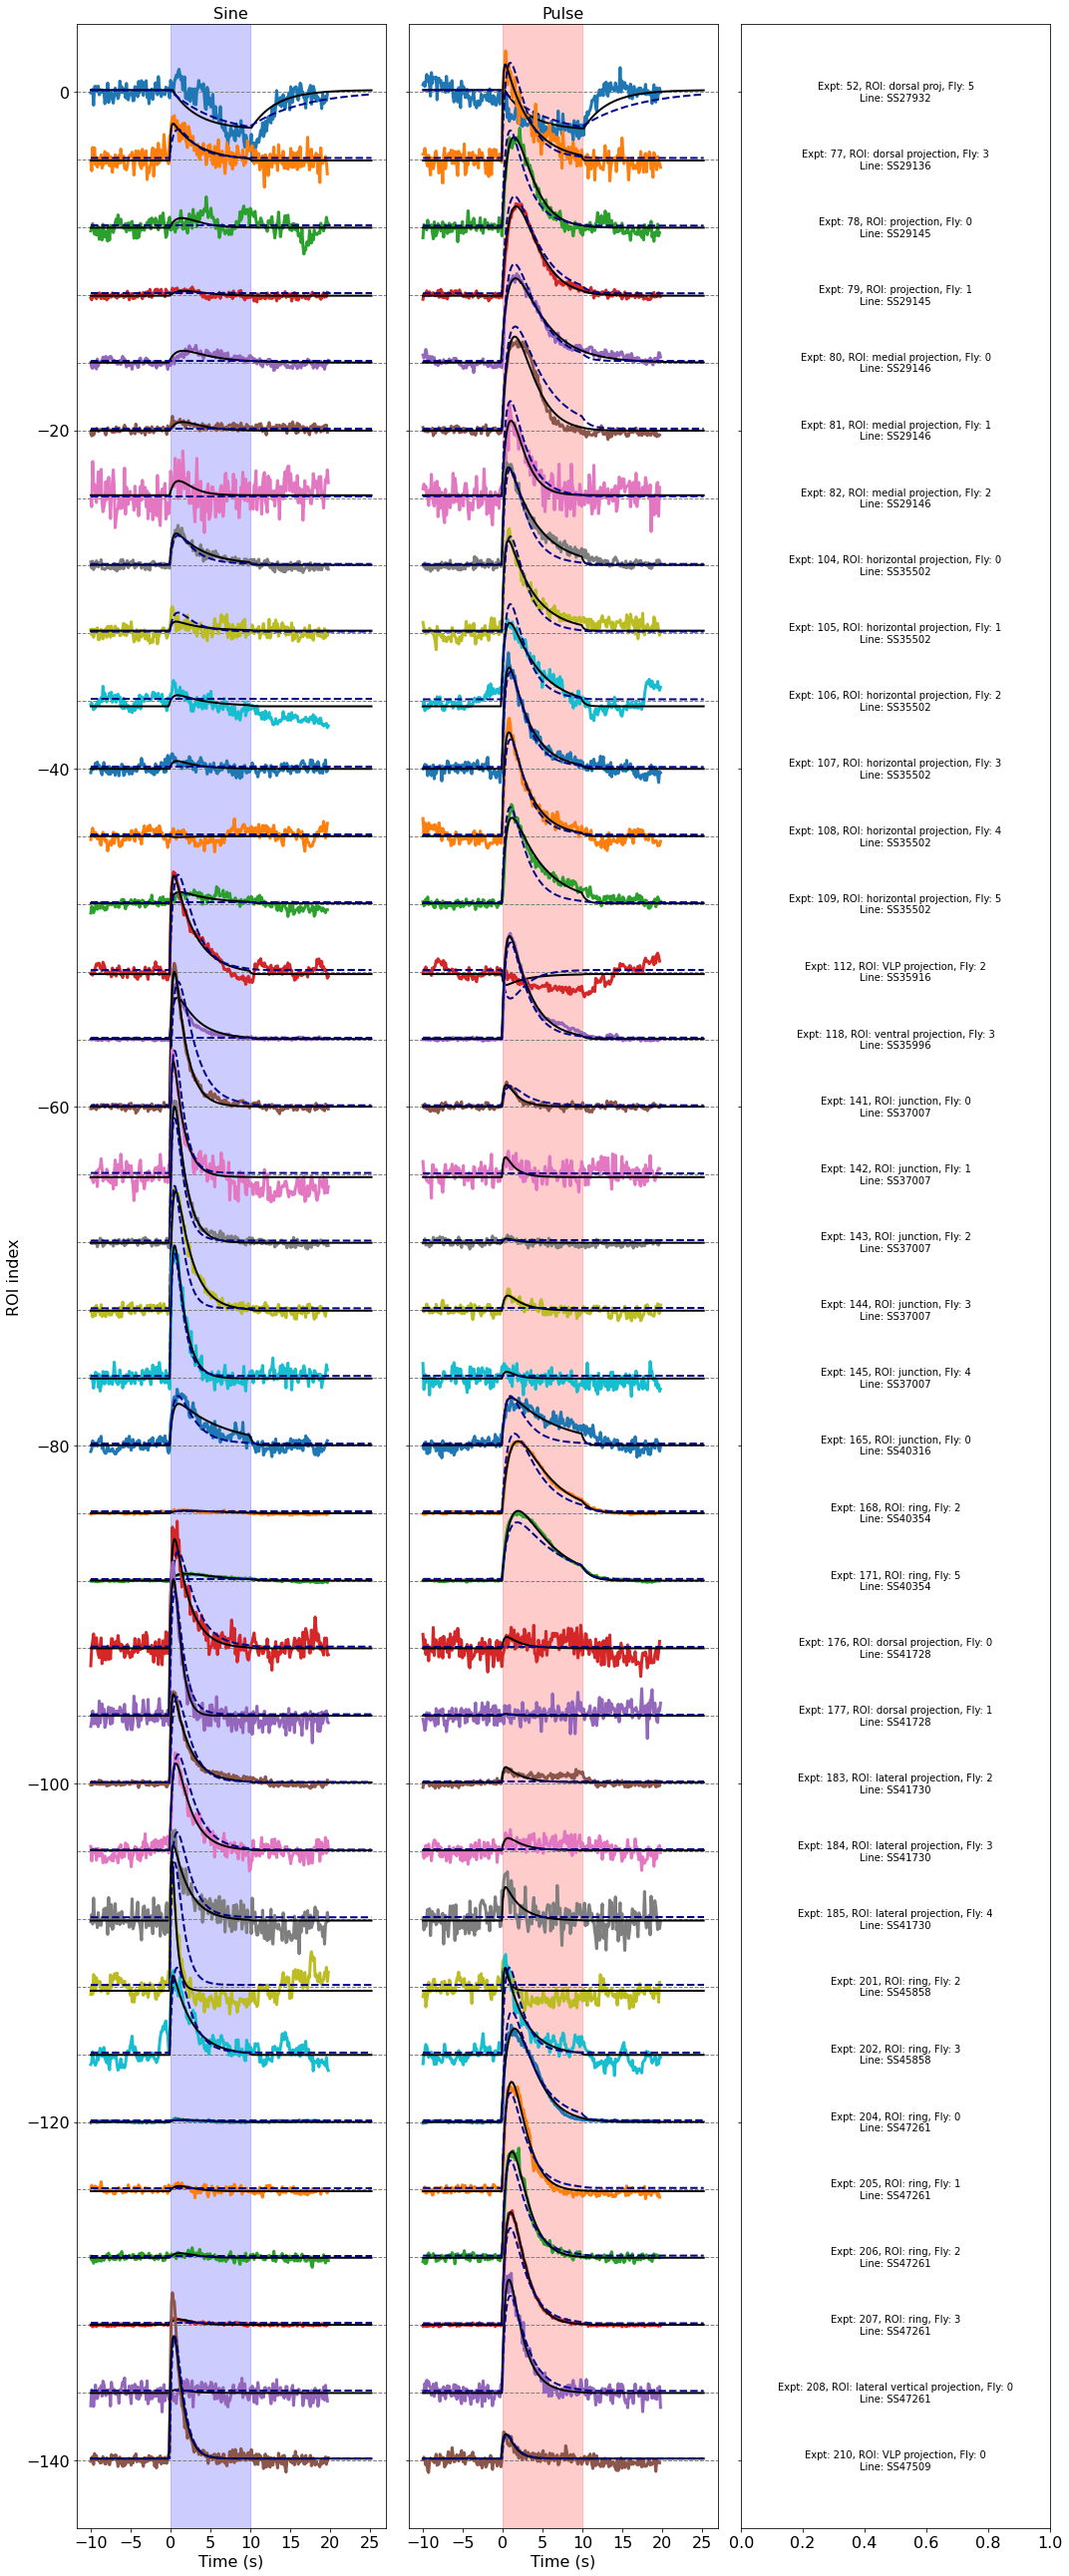

In [8]:
# subset of ROIs
expt_ids_plot = list(df_param_0_dyn['EXPT_ID'])
nroi_plot = len(expt_ids_plot)
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, ROI: {roi}, Fly: {fly}\nLine: {line}', ha='center', va='center')
    
    # saved prediction
    ## sine response
    row_s = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
    # prediction simulated from initial parameters
    if expt_id in list(df_param_0_dyn['EXPT_ID']):
        t_0 = df_param_0_dyn['T_0'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
        r_0 = df_param_0_dyn['R_0'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
        tau_r = df_param_0_dyn['TAU_R'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
        tau_a = df_param_0_dyn['TAU_A'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
        x_s = df_param_0_dyn['X_S'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
        x_p = df_param_0_dyn['X_P'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]

        ## sine response
        axs[0].plot(T, smlt(tau_r, tau_a, x_s, x_p, t_0, 's') + r_0 - 4*cexpt, lw=2, c='darkblue', ls='--')
        ## pulse response
        axs[1].plot(T, smlt(tau_r, tau_a, x_s, x_p, t_0, 'p') + r_0 - 4*cexpt, lw=2, c='darkblue', ls='--')

axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)

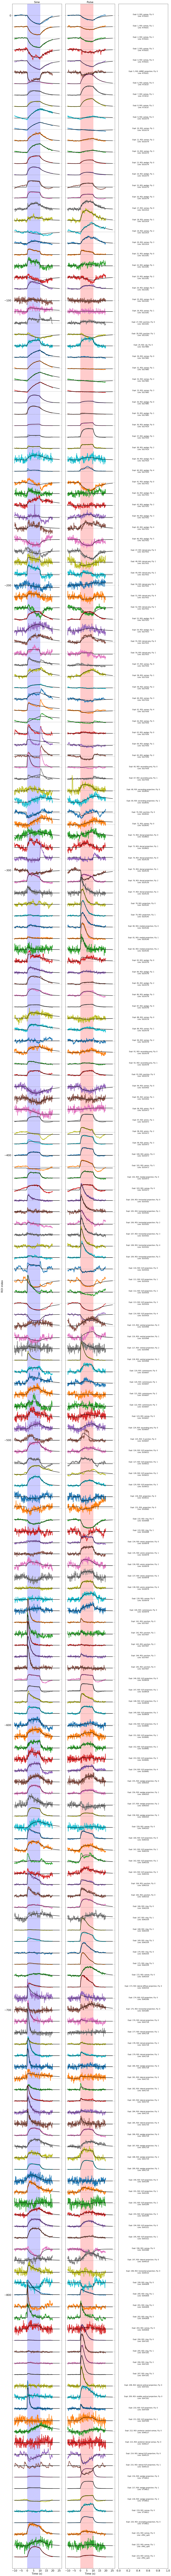

In [9]:
# all ROIs
nroi_plot = 224
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids[:nroi_plot]):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, ROI: {roi}, Fly: {fly}\nLine: {line}', ha='center', va='center')
    
    # saved prediction
    ## sine response
    row_s = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
#     ## prediction simulated from saved parameters
#     t_0 = df_param_dyn['T_0'][df_param_dyn['EXPT_ID'] == expt_id].iloc[0]
#     r_0 = df_param_dyn['R_0'][df_param_dyn['EXPT_ID'] == expt_id].iloc[0]
#     tau_r = df_param_dyn['TAU_R'][df_param_dyn['EXPT_ID'] == expt_id].iloc[0]
#     tau_a = df_param_dyn['TAU_A'][df_param_dyn['EXPT_ID'] == expt_id].iloc[0]
#     x_s = df_param_dyn['X_S'][df_param_dyn['EXPT_ID'] == expt_id].iloc[0]
#     x_p = df_param_dyn['X_P'][df_param_dyn['EXPT_ID'] == expt_id].iloc[0]
    
#     ## sine response
#     axs[0].plot(T, smlt(tau_r, tau_a, x_s, x_p, t_0, 's') + r_0 - 4*cexpt, lw=2, c='gray', ls='--')
#     ## pulse response
#     axs[1].plot(T, smlt(tau_r, tau_a, x_s, x_p, t_0, 'p') + r_0 - 4*cexpt, lw=2, c='gray', ls='--')
    
#     ## prediction simulated from initial parameters
#     if expt_id in list(df_param_0_dyn['EXPT_ID']):
#         t_0 = df_param_0_dyn['T_0'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
#         r_0 = df_param_0_dyn['R_0'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
#         tau_r = df_param_0_dyn['TAU_R'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
#         tau_a = df_param_0_dyn['TAU_A'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
#         x_s = df_param_0_dyn['X_S'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]
#         x_p = df_param_0_dyn['X_P'][df_param_0_dyn['EXPT_ID'] == expt_id].iloc[0]

#         ## sine response
#         axs[0].plot(T, smlt(tau_r, tau_a, x_s, x_p, t_0, 's') + r_0 - 4*cexpt, lw=2, c='darkblue', ls='--')
#         ## pulse response
#         axs[1].plot(T, smlt(tau_r, tau_a, x_s, x_p, t_0, 'p') + r_0 - 4*cexpt, lw=2, c='darkblue', ls='--')

axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)

Show specific examples

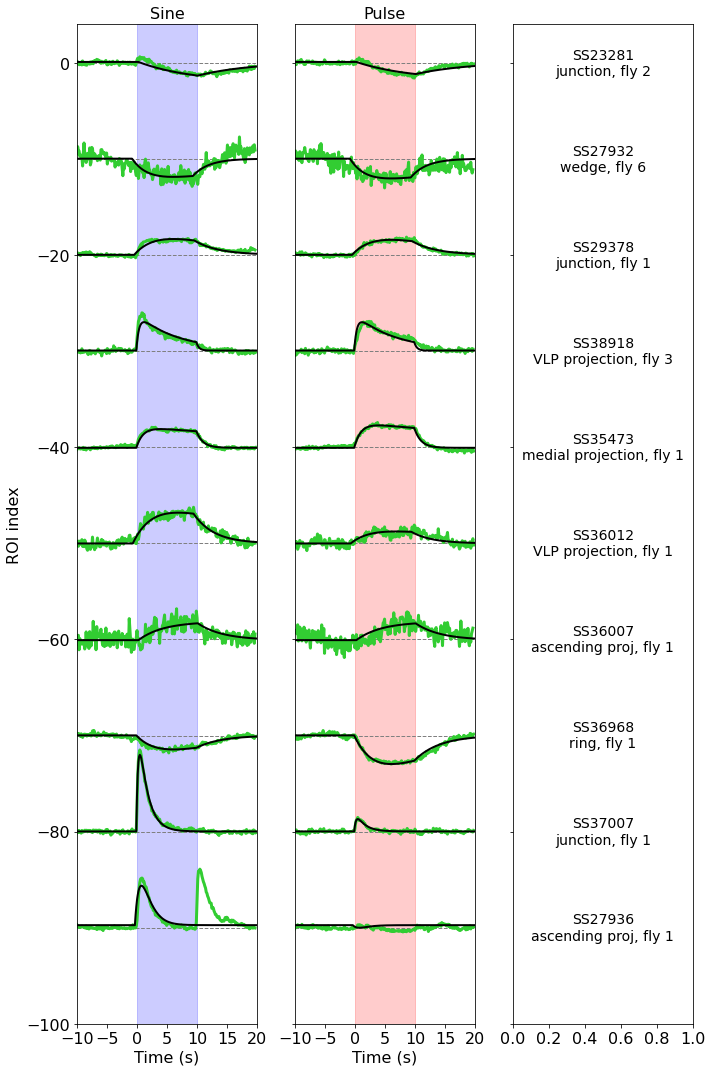

In [10]:
expt_ids_plot = [28, 46, 93, 148, 102, 126, 124, 132, 141, 66]
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(10, 1.5*len(expt_ids_plot)), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-10*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 10*cexpt, lw=3, c='limegreen')
    
    roi = row_s['ROI']
    fly = row_s['FLY']
    line = row_s['LINE']
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-10*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 10*cexpt, lw=3, c='limegreen')
    
#     axs[2].text(0.5, -10*cexpt, f'Line: {line}\n{roi}, fly {fly+1}\n(Response {expt_id})', ha='center', va='center', fontsize=14)
    axs[2].text(0.5, -10*cexpt, f'{line}\n{roi}, fly {fly+1}', ha='center', va='center', fontsize=14)
    
    # prediction
    ## sine response
    row_s = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 10*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 10*cexpt, lw=2, c='k')
    
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_xlim(-10, 20)
    ax.set_ylim(-10*len(expt_ids_plot), 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)